In [31]:
!pip install pyspark
!pip install azure-storage-blob
!pip install findspark


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\shams\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\shams\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\shams\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [32]:
# from google.colab import files
# uploaded = files.upload()


In [ ]:
import os  # Access OS features like environment variables
import findspark  # Makes Spark usable in non-Spark environments 
from pyspark.sql import SparkSession # Starts a Spark session to work with big data
from azure.storage.blob import BlobServiceClient # Connects to Azure Blob Storage for reading/writing files
from pyspark.sql.functions import rand # Adds random numbers to DataFrames

# Initialize Spark session
findspark.init()
spark = SparkSession.builder.appName("AzureBlobSpark").getOrCreate()


# Function to upload a file to Azure Blob Storage
def upload_to_blob_storage(storage_account_name, storage_account_key, container_name, local_file_path, blob_name):
    connection_string = f"DefaultEndpointsProtocol=https;AccountName={storage_account_name};AccountKey={storage_account_key};EndpointSuffix=core.windows.net"
    blob_service_client = BlobServiceClient.from_connection_string(connection_string)
    container_client = blob_service_client.get_container_client(container_name)

    try:
        # Create the container if it doesn't exist
        if not container_client.exists():
            container_client.create_container()
            print(f"Container '{container_name}' created.")
    except Exception as e:
        print(f"Error checking/creating container: {e}")

    blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)

    try:
        with open(local_file_path, "rb") as data:
            blob_client.upload_blob(data, overwrite=True)
        print(f"File {local_file_path} uploaded to {container_name}/{blob_name}")
        return True
    except Exception as e:
        print(f"Error uploading blob: {e}")
        return False

# Function to download blob from Azure Blob Storage to local path
def download_blob_to_local(storage_account_name, storage_account_key, container_name, dataset_name, local_path):
    connection_string = f"DefaultEndpointsProtocol=https;AccountName={storage_account_name};AccountKey={storage_account_key};EndpointSuffix=core.windows.net"
    blob_service_client = BlobServiceClient.from_connection_string(connection_string)
    blob_client = blob_service_client.get_blob_client(container=container_name, blob=dataset_name)

    try:
        with open(local_path, "wb") as f:
            f.write(blob_client.download_blob().readall())
        print(f" File downloaded to {local_path}")
        return True
    except Exception as e:
        print(f" Error downloading blob: {e}")
        return False

# Function to load a dataset into a Spark DataFrame
def load_dataset_into_spark(local_path):
    return spark.read.option("header", True).csv(local_path)

# Define the variables
storage_account_name = "yellowdata1"
storage_account_key = "YOUR_KEY_HERE"
container_name = "yellowdata"
dataset_name = "yellow_final.csv"
local_path = f"./{dataset_name}"

# For local file that needs to be uploaded
source_file_path = "./yellow_final.csv"

# Upload the dataset to Azure Blob Storage
if os.path.exists(source_file_path):
    if upload_to_blob_storage(storage_account_name, storage_account_key, container_name, source_file_path, dataset_name):
        print("Successfully uploaded dataset to Azure Blob Storage")
    else:
        print("Failed to upload dataset to Azure Blob Storage")
else:
    print(f"Source file {source_file_path} not found. Skipping upload.")

# Download the dataset to the local file system
if not download_blob_to_local(storage_account_name, storage_account_key, container_name, dataset_name, local_path):
    print("Failed to download the dataset.")
    exit()

# Load the dataset into Spark
df = load_dataset_into_spark(local_path)

# Shuffle the DataFrame by ordering it randomly
df = df.orderBy(rand())

# Show the first 5 rows of the DataFrame
df.show(5)



File ./yellow_final.csv uploaded to yellowdata/yellow_final.csv
Successfully uploaded dataset to Azure Blob Storage
 File downloaded to ./yellow_final.csv
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-01-04 14:09:41| 

In [34]:
# Print the schema of the DataFrame
df.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)
 |-- congestion_surcharge: string (nullable = true)
 |-- Airport_fee: string (nullable = true)



In [35]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType, IntegerType, TimestampType

# Cast the columns to appropriate data types
df = df.withColumn("passenger_count", col("passenger_count").cast(IntegerType())) \
       .withColumn("trip_distance", col("trip_distance").cast(FloatType())) \
       .withColumn("fare_amount", col("fare_amount").cast(FloatType())) \
       .withColumn("extra", col("extra").cast(FloatType())) \
       .withColumn("mta_tax", col("mta_tax").cast(FloatType())) \
       .withColumn("tip_amount", col("tip_amount").cast(FloatType())) \
       .withColumn("tolls_amount", col("tolls_amount").cast(FloatType())) \
       .withColumn("improvement_surcharge", col("improvement_surcharge").cast(FloatType())) \
       .withColumn("total_amount", col("total_amount").cast(FloatType())) \
       .withColumn("congestion_surcharge", col("congestion_surcharge").cast(FloatType())) \
       .withColumn("Airport_fee", col("Airport_fee").cast(FloatType())) \
       .withColumn("tpep_pickup_datetime", col("tpep_pickup_datetime").cast(TimestampType())) \
       .withColumn("tpep_dropoff_datetime", col("tpep_dropoff_datetime").cast(TimestampType())) \
       .withColumn("PULocationID", col("PULocationID").cast(IntegerType())) \
       .withColumn("DOLocationID", col("DOLocationID").cast(IntegerType()))

# Show the schema after casting
df.printSchema()

# Show the first 5 rows of the DataFrame
df.show(5)


root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- extra: float (nullable = true)
 |-- mta_tax: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- improvement_surcharge: float (nullable = true)
 |-- total_amount: float (nullable = true)
 |-- congestion_surcharge: float (nullable = true)
 |-- Airport_fee: float (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------

In [36]:
# Get basic statistics for numerical columns
df.describe().show()


+-------+-------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------+------------------+--------------------+------------------+
|summary|           VendorID|   passenger_count|     trip_distance|       RatecodeID|store_and_fwd_flag|     PULocationID|     DOLocationID|      payment_type|       fare_amount|             extra|           mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|       Airport_fee|
+-------+-------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------+------------------+--------------------+------------

In [37]:
from pyspark.sql.functions import col

# Calculate the IQR for the column 'trip_distance' (example)
q1 = df.approxQuantile("trip_distance", [0.25], 0.01)[0]
q3 = df.approxQuantile("trip_distance", [0.75], 0.01)[0]
iqr = q3 - q1

# Define the bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter rows that are outliers
outliers = df.filter((col("trip_distance") < lower_bound) | (col("trip_distance") > upper_bound))

# Show outliers
outliers.show(5)


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-01-04 19:45:23|  2024-01-04 20:19:33|              1|        18.17|       2.0|                 N|         132|         113|           1|       70.0|  5.0|    0.5|     17.1

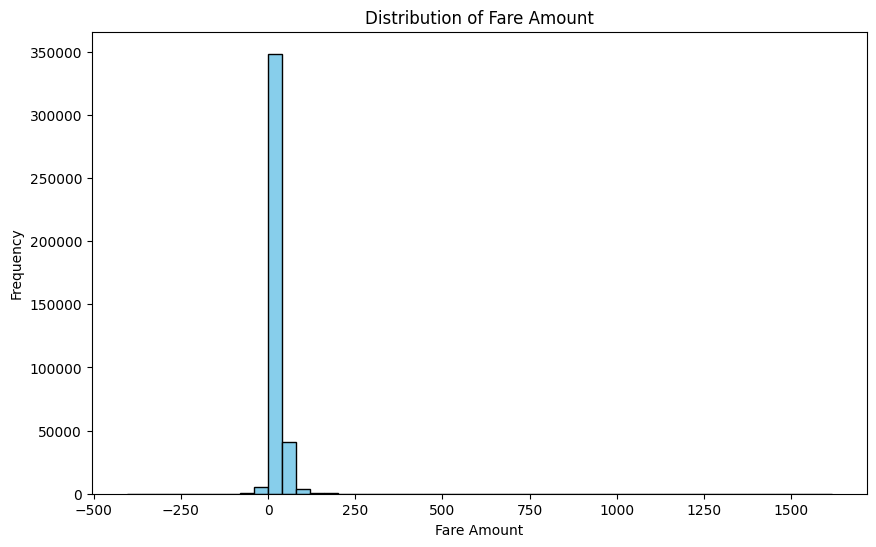

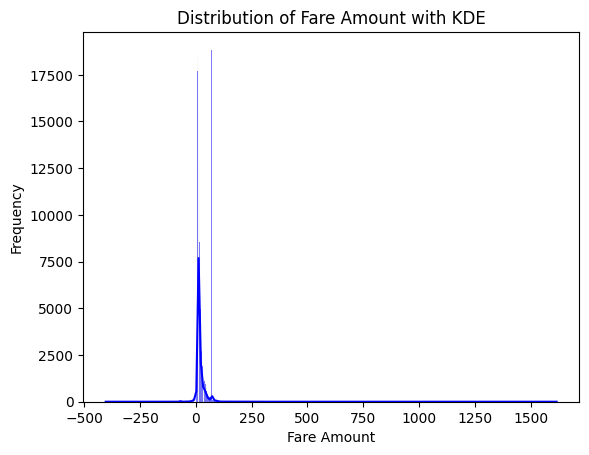

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Collect data for 'fare_amount' into a Pandas DataFrame
fare_data = df.select("fare_amount").toPandas()

# Plot histogram using matplotlib
plt.figure(figsize=(10, 6))
plt.hist(fare_data['fare_amount'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Fare Amount")
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.show()

# Alternatively, using seaborn for a nicer plot
sns.histplot(fare_data['fare_amount'], kde=True, color='blue')
plt.title("Distribution of Fare Amount with KDE")
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.show()


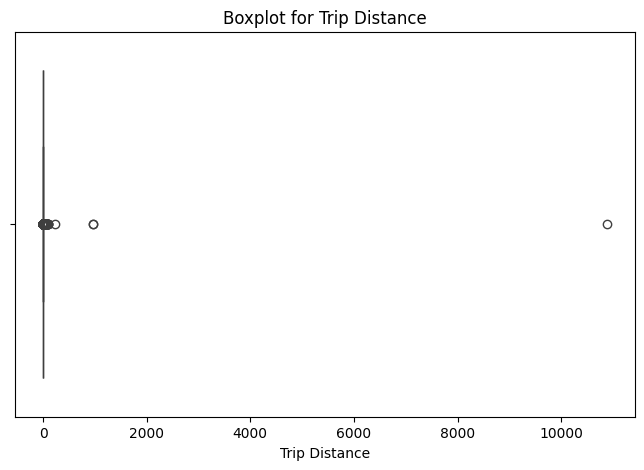

In [39]:
# Collect data for 'trip_distance' into a Pandas DataFrame
trip_distance_data = df.select("trip_distance").toPandas()

# Plot boxplot using seaborn
plt.figure(figsize=(8, 5))
sns.boxplot(x=trip_distance_data['trip_distance'])
plt.title("Boxplot for Trip Distance")
plt.xlabel("Trip Distance")
plt.show()


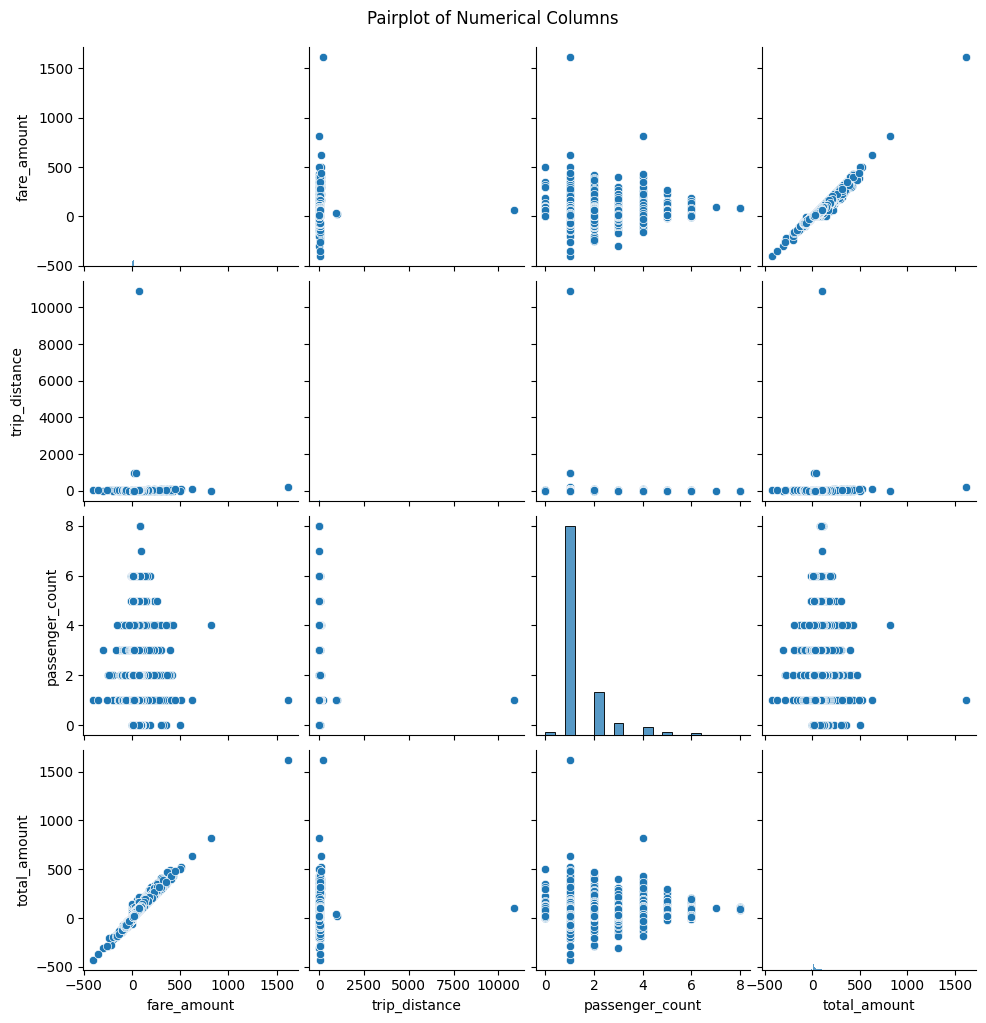

In [40]:
import seaborn as sns

# Collect data for relevant numerical columns
numerical_columns = ["fare_amount", "trip_distance", "passenger_count", "total_amount"]
df_numerical = df.select(numerical_columns).toPandas()

# Create a pairplot to see relationships between columns
sns.pairplot(df_numerical)
plt.suptitle("Pairplot of Numerical Columns", y=1.02)
plt.show()


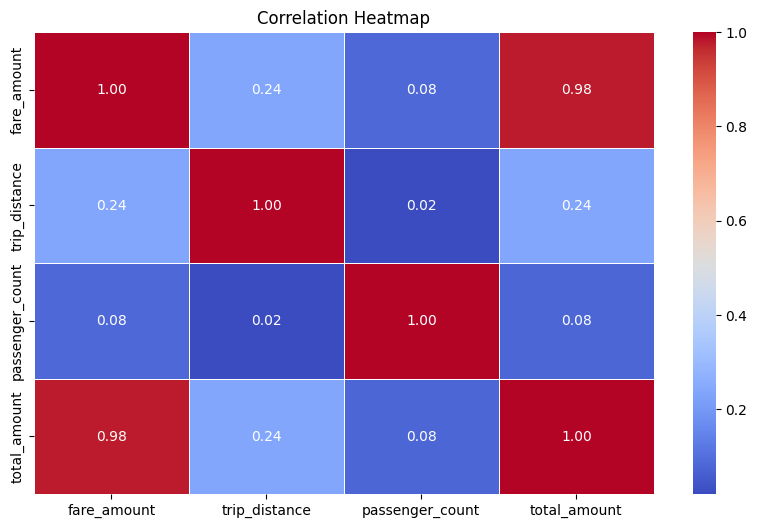

In [41]:
import seaborn as sns

# Collect numerical columns and calculate correlation matrix
df_numerical = df.select(numerical_columns).toPandas()
correlation_matrix = df_numerical.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


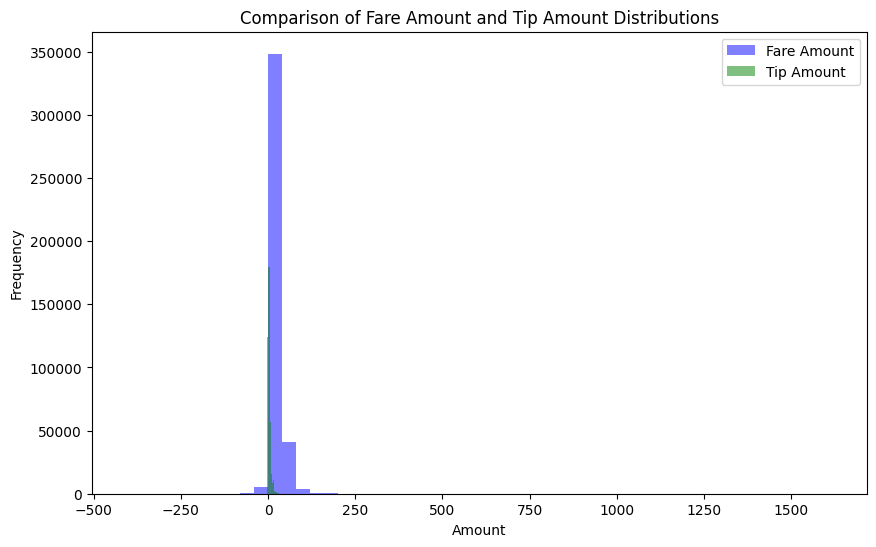

In [42]:
# Collect data for 'fare_amount' and 'tip_amount'
df_histogram = df.select("fare_amount", "tip_amount").toPandas()

# Plot histograms for multiple variables on the same axes
plt.figure(figsize=(10, 6))
plt.hist(df_histogram['fare_amount'], bins=50, alpha=0.5, label='Fare Amount', color='blue')
plt.hist(df_histogram['tip_amount'], bins=50, alpha=0.5, label='Tip Amount', color='green')
plt.title("Comparison of Fare Amount and Tip Amount Distributions")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.legend()
plt.show()


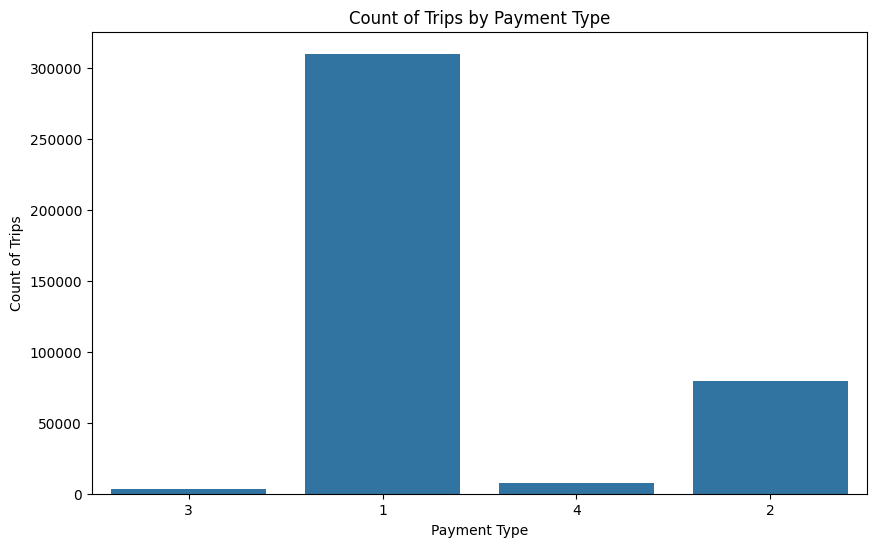

In [43]:
# Collect data for 'payment_type' and the count of occurrences
df_bar = df.groupBy("payment_type").count().toPandas()

# Create a bar plot for the count of each payment type
plt.figure(figsize=(10, 6))
sns.barplot(x='payment_type', y='count', data=df_bar)
plt.title("Count of Trips by Payment Type")
plt.xlabel("Payment Type")
plt.ylabel("Count of Trips")
plt.show()


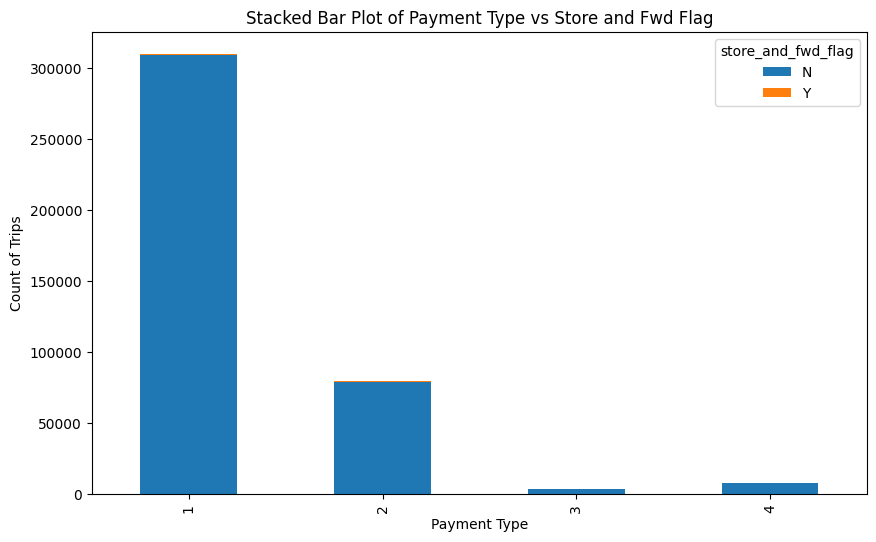

In [44]:
# Collect data for 'payment_type' and 'store_and_fwd_flag'
df_stacked_bar = df.groupBy("payment_type", "store_and_fwd_flag").count().toPandas()

# Pivot the data for stacked bar plot
df_pivot = df_stacked_bar.pivot(index='payment_type', columns='store_and_fwd_flag', values='count')

# Plot the stacked bar plot
df_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Stacked Bar Plot of Payment Type vs Store and Fwd Flag")
plt.xlabel("Payment Type")
plt.ylabel("Count of Trips")
plt.show()


In [45]:
from pyspark.sql.functions import rand

# Shuffle the DataFrame
df_shuffled = df.orderBy(rand())

# Show the first 5 rows of the shuffled data
df_shuffled.show(5)


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-01-05 13:42:58|  2024-01-05 13:46:19|              1|         0.31|       1.0|                 N|         236|         236|           1|        5.1|  0.0|    0.5|      1.8

In [46]:
!pip install mysql-connector-python



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\shams\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [47]:
#Analysis 1: Fare Prediction Based on Trip Distance and Time of Day.
from pyspark.sql.functions import hour
from pyspark.sql import functions as F
import mysql.connector

# Extract the hour from the pickup time (tpep_pickup_datetime)
df = df.withColumn("pickup_hour", hour(df.tpep_pickup_datetime))

# Group by trip distance and pickup hour to calculate the average fare
df_fare_prediction = df.groupBy("trip_distance", "pickup_hour").agg(F.avg("fare_amount").alias("avg_fare"))

# Show the results
df_fare_prediction.show()

# Function to store results in MySQL
def store_dataframe_to_mysql(df, table_name):
    conn = mysql.connector.connect(
        host="localhost",
        user="root",
        password="root",
        database="taxi_analysis"
    )
    cursor = conn.cursor()

    # Create the table if it does not exist
    cursor.execute(f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
            trip_distance FLOAT,
            pickup_hour INT,
            avg_fare FLOAT
        )
    """)

    # Insert data into the table
    for row in df.collect():
        cursor.execute(f"""
            INSERT INTO {table_name} (trip_distance, pickup_hour, avg_fare)
            VALUES (%s, %s, %s)
        """, (row['trip_distance'], row['pickup_hour'], row['avg_fare']))

    # Commit the transaction
    conn.commit()

    # Close the connection
    cursor.close()
    conn.close()

# Store the results of fare prediction analysis in MySQL
store_dataframe_to_mysql(df_fare_prediction, "fare_prediction_final")


+-------------+-----------+------------------+
|trip_distance|pickup_hour|          avg_fare|
+-------------+-----------+------------------+
|         1.63|         13| 12.49827583904924|
|         3.64|         11| 22.39999989100865|
|         0.99|          8| 8.095833390951157|
|         1.49|         16|11.810810830142048|
|         5.99|         21|29.425000190734863|
|         1.11|          1|  8.77500011920929|
|        20.62|         12|             73.25|
|        18.47|         19|              70.0|
|        12.21|         13|52.233333587646484|
|         9.07|         23|36.599998474121094|
|          2.3|         19|14.351908356178807|
|          3.3|         16|20.974999969655816|
|         3.13|         17|20.682608728823453|
|          0.4|         10| 5.312500011175871|
|         1.95|         18|12.671153820477999|
|         1.36|         12|11.039999968664986|
|         0.67|         19| 6.720000010270339|
|         1.47|         19|10.694117609192343|
|         3.5

In [48]:
import mysql.connector

# Function to store the location-based trip count data in MySQL
def store_dataframe_to_mysql_analysis2(df, table_name):
    # Create MySQL connection
    conn = mysql.connector.connect(
        host="localhost",
        user="root",
        password="root",
        database="taxi_analysis"
    )
    cursor = conn.cursor()

    # Get the column names of the DataFrame
    columns = df.columns

    # Create table query dynamically based on column names and types
    create_table_query = f"CREATE TABLE IF NOT EXISTS {table_name} ("

    for column in columns:
        # Detect the column type from the DataFrame schema and assign appropriate MySQL types
        if df.schema[column].dataType.simpleString() == "integer":
            column_type = "INT"
        elif df.schema[column].dataType.simpleString() == "long":
            column_type = "BIGINT"
        else:
            column_type = "VARCHAR(255)"

        create_table_query += f"{column} {column_type}, "

    # Remove the trailing comma and space, and close the parentheses
    create_table_query = create_table_query.rstrip(", ") + ")"

    # Execute the table creation
    cursor.execute(create_table_query)

    # Insert data into the table
    for row in df.collect():
        insert_query = f"INSERT INTO {table_name} ({', '.join(columns)}) VALUES ({', '.join(['%s'] * len(columns))})"
        cursor.execute(insert_query, tuple(row))

    # Commit the transaction
    conn.commit()

    # Close the connection
    cursor.close()
    conn.close()


In [49]:
#Analysis 2: Identifying High-Demand Pickup Locations
# Group by pickup location and count the number of trips
df_location_trip_count = df.groupBy("PULocationID").agg(F.count("fare_amount").alias("trip_count"))

# Show the regions with the highest number of trips
df_location_trip_count.show()
# Print the schema to check the column names
df_location_trip_count.printSchema()

# Show the first few rows to verify data
df_location_trip_count.show(5)

# Store the results in MySQL
store_dataframe_to_mysql_analysis2(df_location_trip_count, "location_trip_count_final")


+------------+----------+
|PULocationID|trip_count|
+------------+----------+
|         148|      2740|
|         243|        72|
|         137|      4342|
|         251|         1|
|          85|        29|
|          65|       235|
|         255|       100|
|          78|        31|
|         108|        18|
|         211|      2510|
|          34|         7|
|         193|       354|
|         126|        14|
|          81|        18|
|          28|        57|
|          76|       127|
|         159|        36|
|         236|     16317|
|          12|       263|
|         223|        74|
+------------+----------+
only showing top 20 rows

root
 |-- PULocationID: integer (nullable = true)
 |-- trip_count: long (nullable = false)

+------------+----------+
|PULocationID|trip_count|
+------------+----------+
|         148|      2740|
|         243|        72|
|         137|      4342|
|         251|         1|
|          85|        29|
+------------+----------+
only showing top 5 rows


In [50]:
#Analysis 3: Trip Duration and Fare Analysis Based on Trip Distance,
from pyspark.sql.functions import unix_timestamp

# Calculate trip duration (in minutes)
df_trip_duration_fare = df.withColumn("trip_duration",
                                     (unix_timestamp(df.tpep_dropoff_datetime) - unix_timestamp(df.tpep_pickup_datetime)) / 60)

# Group by trip distance and calculate the average fare and average trip duration
df_trip_summary = df_trip_duration_fare.groupBy("trip_distance").agg(
    F.avg("fare_amount").alias("avg_fare"),
    F.avg("trip_duration").alias("avg_trip_duration")
)

# Show the results
df_trip_summary.show()


+-------------+------------------+------------------+
|trip_distance|          avg_fare| avg_trip_duration|
+-------------+------------------+------------------+
|         6.83|33.192857197352815|24.647023809523805|
|        19.67| 72.06666666666666| 42.10388888888888|
|         3.32|   19.419758096818| 18.53286290322581|
|         8.26| 33.18378396936365|21.536936936936936|
|          9.1| 39.53041235933599|29.463831615120277|
|        12.64| 56.52307715782752| 34.44358974358975|
|        20.11| 77.42941194422104| 51.35686274509804|
|        28.89| 137.0500030517578|            43.675|
|        19.44| 68.66842129355983| 35.86491228070175|
|         9.87| 41.00714283897763|27.610714285714288|
|          9.4| 39.72045460614291| 28.68106060606061|
|         4.96| 26.15842701344008|  23.7314606741573|
|         5.85|26.930434821308523|21.557971014492754|
|        23.95| 98.04999923706055| 36.63333333333333|
|        21.02| 72.80625009536743|            43.825|
|        13.22| 58.030000305

In [51]:
# Function to store the results of trip summary in MySQL
def store_dataframe_to_mysql_analysis3(df, table_name):
    # Create MySQL connection
    conn = mysql.connector.connect(
        host="localhost",
        user="root",
        password="root",
        database="taxi_analysis"
    )
    cursor = conn.cursor()

    # Get the column names of the DataFrame
    columns = df.columns

    # Create table query dynamically based on column names and types
    create_table_query = f"CREATE TABLE IF NOT EXISTS {table_name} ("

    for column in columns:
        # Detect the column type from the DataFrame schema and assign appropriate MySQL types
        if df.schema[column].dataType.simpleString() == "integer":
            column_type = "INT"
        elif df.schema[column].dataType.simpleString() == "long":
            column_type = "BIGINT"
        elif df.schema[column].dataType.simpleString() == "float":
            column_type = "FLOAT"
        else:
            column_type = "VARCHAR(255)"

        create_table_query += f"{column} {column_type}, "

    # Remove the trailing comma and space, and close the parentheses
    create_table_query = create_table_query.rstrip(", ") + ")"

    # Execute the table creation query
    cursor.execute(create_table_query)

    # Insert data into the table
    for row in df.collect():
        insert_query = f"INSERT INTO {table_name} ({', '.join(columns)}) VALUES ({', '.join(['%s'] * len(columns))})"
        cursor.execute(insert_query, tuple(row))

    # Commit the transaction
    conn.commit()

    # Close the connection
    cursor.close()
    conn.close()

# Store the results of trip summary analysis in MySQL
store_dataframe_to_mysql_analysis3(df_trip_summary, "trip_summary_final")


In [52]:
import mysql.connector
import pandas as pd

# Function to fetch data from MySQL and save as CSV
def fetch_data_and_save_csv(query, filename):
    # Create a MySQL connection
    conn = mysql.connector.connect(
        host="localhost",
        user="root",
        password="root",
        database="taxi_analysis"
    )

    # Use pandas to fetch the data and store it in a DataFrame
    df_mysql = pd.read_sql(query, conn)

    # Save to CSV
    df_mysql.to_csv(filename, index=False)

    # Close the connection
    conn.close()

# Fetch the fare prediction data and save it to CSV
fetch_data_and_save_csv("SELECT * FROM fare_prediction_final", "fare_prediction_final.csv")

# Fetch the location trip count data and save it to CSV
fetch_data_and_save_csv("SELECT * FROM location_trip_count_final", "location_trip_count_final.csv")

# Fetch the trip summary data and save it to CSV
fetch_data_and_save_csv("SELECT * FROM trip_summary_final", "trip_summary_final.csv")


C:\Users\shams\AppData\Local\Temp\ipykernel_16556\1853570964.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_mysql = pd.read_sql(query, conn)


In [53]:
# After fetching data and creating CSV
import pandas as pd

# Read the CSV to see what's in it
test_df = pd.read_csv("location_trip_count_final.csv")
print("CSV contents (first 20 rows):")
print(test_df.head(20))
print("\nNumber of unique PULocationIDs:", test_df['PULocationID'].nunique())

CSV contents (first 20 rows):
    PULocationID  trip_count
0            148        2740
1            243          72
2            137        4342
3            251           1
4             85          29
5             65         235
6            255         100
7             78          31
8            108          18
9            211        2510
10            34           7
11           193         354
12           126          14
13            81          18
14            28          57
15            76         127
16           159          36
17           236       16317
18            12         263
19           223          74

Number of unique PULocationIDs: 239


In [54]:
# Load the data from CSV files into Pandas DataFrames
fare_data = pd.read_csv("fare_prediction_final.csv")
location_data = pd.read_csv("location_trip_count_final.csv")
trip_data = pd.read_csv("trip_summary_final.csv")

# Display the first few rows of each DataFrame to verify data
print(fare_data.head())
print(location_data.head())
print(trip_data.head())


   trip_distance  pickup_hour  avg_fare
0           0.67           19    6.7200
1           1.11            1    8.7750
2           0.55           14    6.2000
3           1.47           19   10.6941
4           0.31            6    4.0500
   PULocationID  trip_count
0           148        2740
1           243          72
2           137        4342
3           251           1
4            85          29
   trip_distance   avg_fare  avg_trip_duration
0          12.64  56.523077          34.443590
1           8.26  33.183784          21.536937
2           3.32  19.419758          18.532863
3           6.83  33.192857          24.647024
4           9.10  39.530412          29.463832


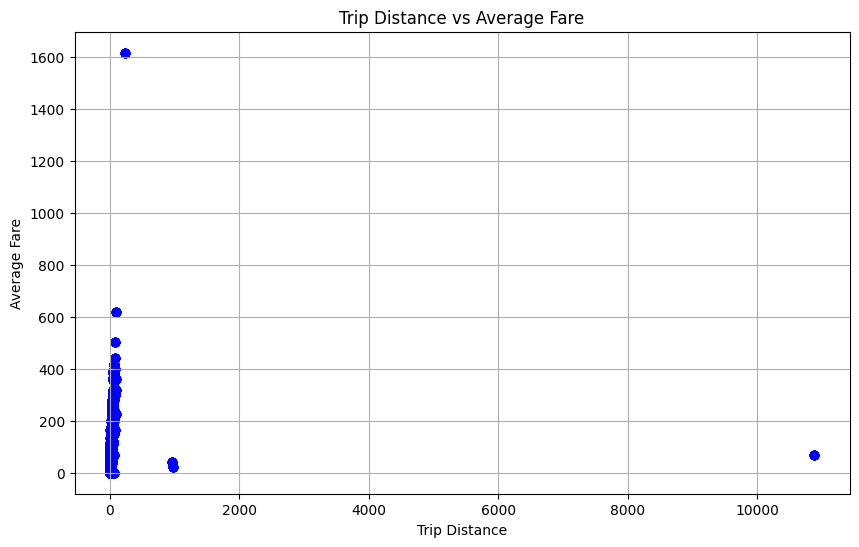

In [55]:
import matplotlib.pyplot as plt
#analsyis 1 plots
# Plot the relationship between Trip Distance and Average Fare
plt.figure(figsize=(10, 6))
plt.scatter(fare_data['trip_distance'], fare_data['avg_fare'], color='blue', label='Fare')
plt.title('Trip Distance vs Average Fare')
plt.xlabel('Trip Distance')
plt.ylabel('Average Fare')
plt.grid(True)
plt.show()


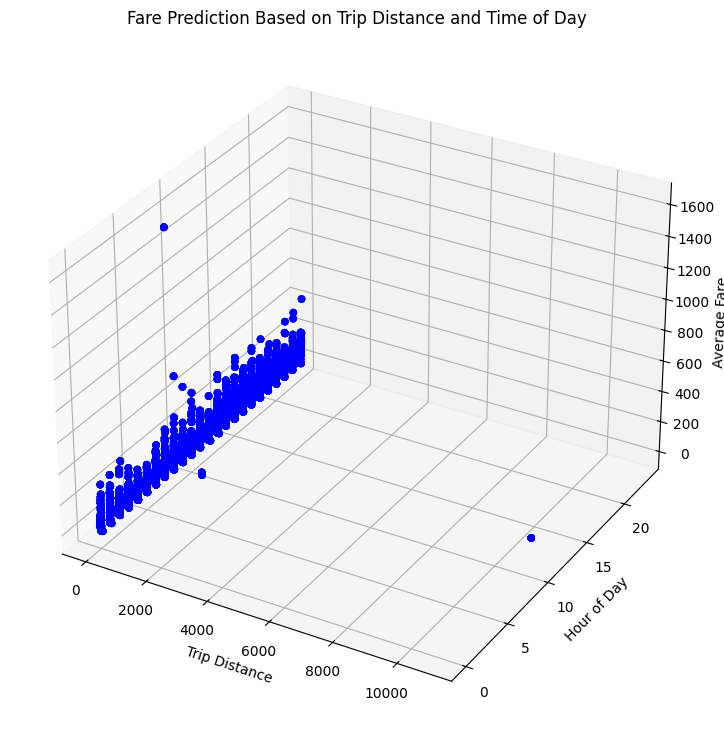

In [56]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Create a 3D plot for fare prediction
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fare_data['trip_distance'], fare_data['pickup_hour'], fare_data['avg_fare'], c='blue', marker='o')
ax.set_xlabel('Trip Distance')
ax.set_ylabel('Hour of Day')
ax.set_zlabel('Average Fare')
plt.title('Fare Prediction Based on Trip Distance and Time of Day')
plt.show()


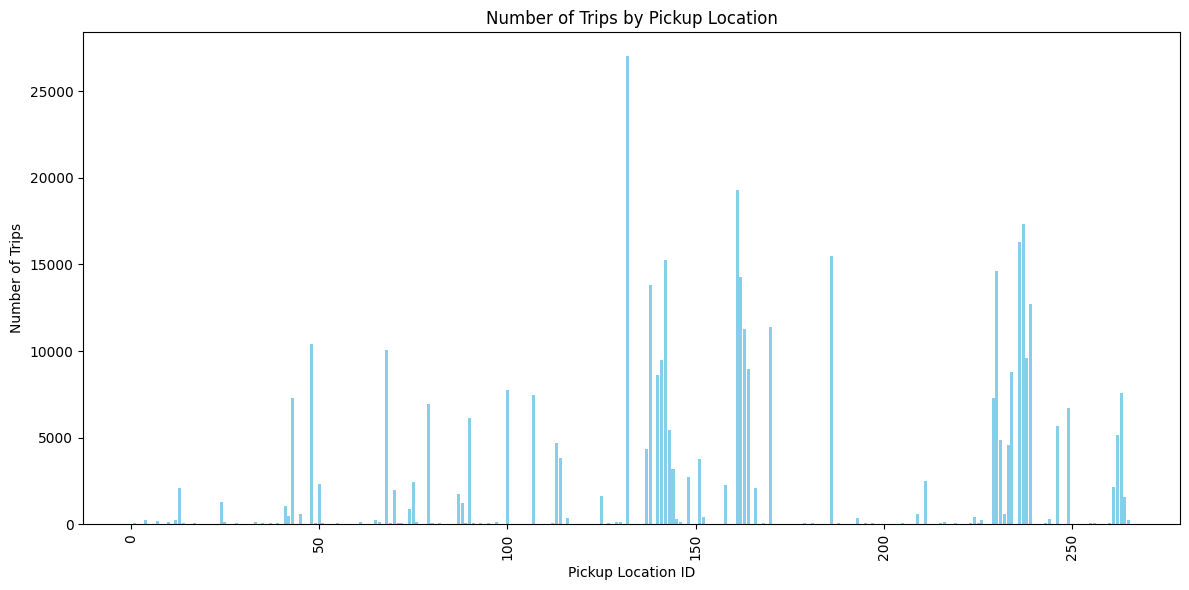

In [57]:
import matplotlib.pyplot as plt

# Sort the data by trip count in descending order
sorted_location_data = location_data.sort_values(by='trip_count', ascending=False)

# Plot the number of trips for each location
plt.figure(figsize=(12, 6))
plt.bar(sorted_location_data['PULocationID'], sorted_location_data['trip_count'], color='skyblue')

# Adding labels and title
plt.title('Number of Trips by Pickup Location')
plt.xlabel('Pickup Location ID')
plt.ylabel('Number of Trips')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping labels

# Show the plot
plt.show()


Top 10 locations (after grouping):
     PULocationID  trip_count
116           132      243387
144           161      173880
211           237      155745
210           236      146853
166           186      139167
126           142      137511
204           230      131760
145           162      128259
122           138      124263
213           239      114192


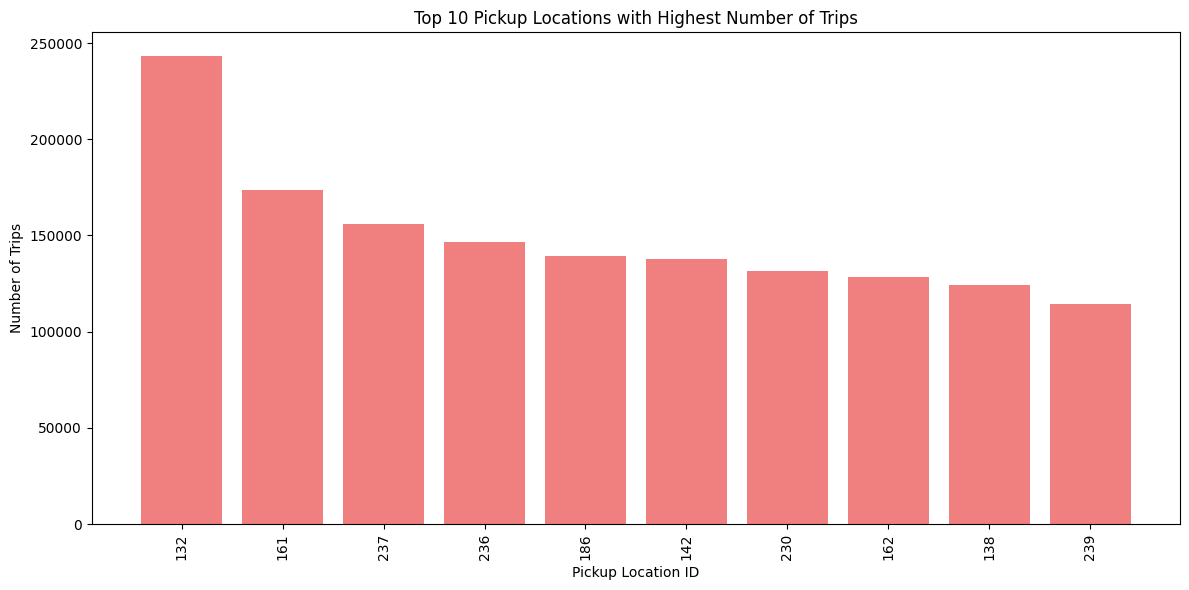

In [58]:

# Read the CSV data
location_data = pd.read_csv("location_trip_count_final.csv")

# Convert to numeric
location_data['trip_count'] = pd.to_numeric(location_data['trip_count'])

# Group by PULocationID and sum the trip counts
grouped_location_data = location_data.groupby('PULocationID')['trip_count'].sum().reset_index()

# Sort by trip count in descending order
sorted_location_data = grouped_location_data.sort_values('trip_count', ascending=False)

# Print the top 10 rows to verify
print("Top 10 locations (after grouping):")
print(sorted_location_data.head(10))

# Select top 10 locations
top_n_locations = sorted_location_data.head(10)

# Plot with evenly spaced bars
plt.figure(figsize=(12, 6))
x_positions = range(len(top_n_locations))
plt.bar(x_positions, top_n_locations['trip_count'], color='lightcoral')
plt.xticks(x_positions, top_n_locations['PULocationID'], rotation=90)
plt.title('Top 10 Pickup Locations with Highest Number of Trips')
plt.xlabel('Pickup Location ID')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()

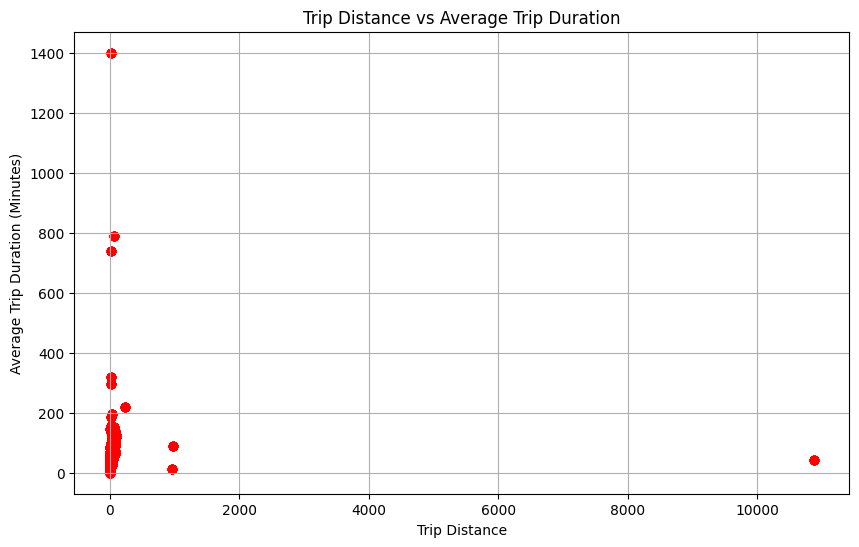

In [59]:
# Plot the relationship between Trip Distance and Average Trip Duration
plt.figure(figsize=(10, 6))
plt.scatter(trip_data['trip_distance'], trip_data['avg_trip_duration'], color='red', label='Duration')
plt.title('Trip Distance vs Average Trip Duration')
plt.xlabel('Trip Distance')
plt.ylabel('Average Trip Duration (Minutes)')
plt.grid(True)
plt.show()


In [60]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Select relevant columns (features and target)
df_ml = df.select('fare_amount', 'trip_distance', 'passenger_count', 'total_amount')

# Assemble the features into a single vector column (making sure this column is unique)
assembler = VectorAssembler(inputCols=['trip_distance', 'passenger_count', 'total_amount'], outputCol='assembled_features')

# Apply the transformation (this is where the 'assembled_features' column is created)
df_ml = assembler.transform(df_ml)

# Split the data into training and test sets (80% training, 20% testing)
train_data, test_data = df_ml.randomSplit([0.8, 0.2], seed=42)

# Initialize the Gradient Boosting Regressor model
gbt = GBTRegressor(labelCol='fare_amount', featuresCol='assembled_features', maxIter=100)

# Fit the model
model = gbt.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)



# Initialize a RegressionEvaluator to evaluate the model's performance
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")

# Calculate the RMSE (Root Mean Squared Error)
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate R2 score
evaluator.setMetricName("r2")
r2 = evaluator.evaluate(predictions)
print(f"R2 Score: {r2}")


Root Mean Squared Error (RMSE): 6.489410167998957
R2 Score: 0.9081797543443567


In [61]:

# Function to create the table if it doesn't exist
def create_model_metrics_table():
    # MySQL connection details
    conn = mysql.connector.connect(
        host="localhost",
        user="root",
        password="root",
        database="taxi_analysis"  # Update with your database name
    )
    cursor = conn.cursor()

    # SQL query to create the model_metrics table
    create_table_query = """
    CREATE TABLE IF NOT EXISTS model_metrics (
        id INT AUTO_INCREMENT PRIMARY KEY,
        model_name VARCHAR(255),
        rmse FLOAT,
        r2 FLOAT,
        timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP
    );
    """
    # Execute the query to create the table
    cursor.execute(create_table_query)
    conn.commit()

    # Close the connection
    cursor.close()
    conn.close()

# Function to store the evaluation metrics in MySQL
def store_model_metrics_in_mysql(model_name, rmse, r2):
    # MySQL connection details
    conn = mysql.connector.connect(
        host="localhost",
        user="root",
        password="root",
        database="taxi_analysis"  # Update with your database name
    )

    cursor = conn.cursor()

    # Insert evaluation metrics into the model_metrics table
    insert_query = """
    INSERT INTO model_metrics (model_name, rmse, r2)
    VALUES (%s, %s, %s)
    """
    cursor.execute(insert_query, (model_name, rmse, r2))

    # Commit the transaction
    conn.commit()

    # Close the connection
    cursor.close()
    conn.close()

# Step 1: Create the model_metrics table if it doesn't already exist
create_model_metrics_table()

# Step 2: Store the model metrics in MySQL
model_name = "GradientBoostingRegressor"

# Store the results in MySQL
store_model_metrics_in_mysql(model_name, rmse, r2)

print(f"Metrics stored in MySQL for {model_name}")


Metrics stored in MySQL for GradientBoostingRegressor


In [62]:
import mysql.connector
import pandas as pd

# Function to fetch data from MySQL and save as CSV
def fetch_data_and_save_csv(query, filename):
    # MySQL connection details
    conn = mysql.connector.connect(
        host="localhost",
        user="root",
        password="root",
        database="taxi_analysis"  # Update with your database name
    )

    # Use pandas to fetch the data and store it in a DataFrame
    df_mysql = pd.read_sql(query, conn)

    # Save to CSV
    df_mysql.to_csv(filename, index=False)

    # Close the connection
    conn.close()

# Fetch the model metrics data from MySQL and save it to CSV
fetch_data_and_save_csv("SELECT * FROM model_metrics", "model_metrics.csv")


C:\Users\shams\AppData\Local\Temp\ipykernel_16556\3614893788.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_mysql = pd.read_sql(query, conn)


In [63]:
# Load the model metrics data from the CSV file
metrics_data = pd.read_csv("model_metrics.csv")

# Display the first few rows to verify data
print(metrics_data.head())


   id                 model_name     rmse        r2            timestamp
0   1  GradientBoostingRegressor  7.22295  0.946301  2025-04-20 16:18:03
1   2  GradientBoostingRegressor  5.17580  0.943144  2025-04-20 16:20:39
2   3  GradientBoostingRegressor  7.03536  0.888873  2025-04-20 16:22:43
3   4  GradientBoostingRegressor  5.68830  0.889251  2025-04-20 16:24:23
4   5  GradientBoostingRegressor  4.98397  0.924035  2025-04-21 11:29:12
